In [1]:
import matplotlib.pyplot as plt
import re
# import networkx as nx
import numpy as np
import pandas as pd
import time
import sys
import os
import datetime

# preamble for jupyter notebook and django
import django
import platform
from django.db.models import Q, F, Sum, Count, FloatField, Case, When

if platform.node() == "mcc-apsis":
    sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from parliament.models import *
from scoping.models import *

In [2]:
p = Project.objects.get(pk=134)
dos = DocOwnership.objects.filter(tag__query__project=p)

utids = dos.values_list("utterance__id",flat=True)

In [3]:
pars = Paragraph.objects.filter(utterance__in=utids)
rekohle = "(\w*(?:K|k)ohle\w+)"
kps = pars.filter(text__iregex=rekohle)

kohle_compounds = set()
for kp in kps:
    for x in re.findall(rekohle,kp.text):
        kohle_compounds.add(x.lower())
        
print(len(kohle_compounds))
        
kohle_compounds

446


{'ballastkohlesorten',
 'braunkohleabbau',
 'braunkohleanteil',
 'braunkohleausschusses',
 'braunkohlebergbau',
 'braunkohlebergbaus',
 'braunkohleeinsatz',
 'braunkohleförderung',
 'braunkohlegebiet',
 'braunkohlegebiete',
 'braunkohlegegnern',
 'braunkohlegroßkraftwerke',
 'braunkohleindustrie',
 'braunkohlekapazitäten',
 'braunkohlekraftwerk',
 'braunkohlekraftwerke',
 'braunkohlekraftwerken',
 'braunkohlemeiler',
 'braunkohlenbergbau',
 'braunkohlenbergbaus',
 'braunkohlenbergwerk',
 'braunkohlenbriketts',
 'braunkohlengewinnung',
 'braunkohlenkraftwerke',
 'braunkohlenplanverfahren',
 'braunkohlenrevier',
 'braunkohlentagebau',
 'braunkohlentagebaue',
 'braunkohlenwerke',
 'braunkohlepfennig',
 'braunkohlepolitik',
 'braunkohleprivilegierung',
 'braunkohleregionen',
 'braunkohlereserve',
 'braunkohlerestseen',
 'braunkohlerevier',
 'braunkohlereviere',
 'braunkohlerevieren',
 'braunkohleruinen',
 'braunkohlesanierung',
 'braunkohlesanierungsgesellschaften',
 'braunkohlestrom',
 'b

In [4]:
kohle_compounds = list(kohle_compounds)

occurences = []
occurences_yes = []
occurences_no = []

for kc in kohle_compounds:
    kc_pars = pars.filter(text__icontains=kc)
    expattern = f"kohle(?!{kc.replace('kohle','')})"
    kc_others = pars.filter(text__iregex=expattern)
    kc_uids = set(kc_pars.values_list('utterance__id',flat=True))
    kc_uids = kc_uids - set(kc_others.values_list('utterance__id',flat=True))
    kc_dos = dos.filter(utterance__in=kc_uids)
    occurences.append(kc_dos.count())
    occurences_yes.append(kc_dos.filter(relevant=1).count())
    occurences_no.append(kc_dos.filter(relevant=2).count())
                          
df = pd.DataFrame({
    "kohle_compound": kohle_compounds,
    "occurences":occurences,
    "yes": occurences_yes,
    "no": occurences_no
}).sort_values('occurences',ascending=False).reset_index(drop=True)

df.head()

,kohle_compound,occurences,yes,no
0,kohlen,116,49,66
1,kohlekraft,56,56,0
2,kohlekraftwerk,54,54,0
3,kohlekraftwerke,40,40,0
4,kohlenwasser,21,0,21


In [5]:
df['av'] = df['yes'] - df['no']

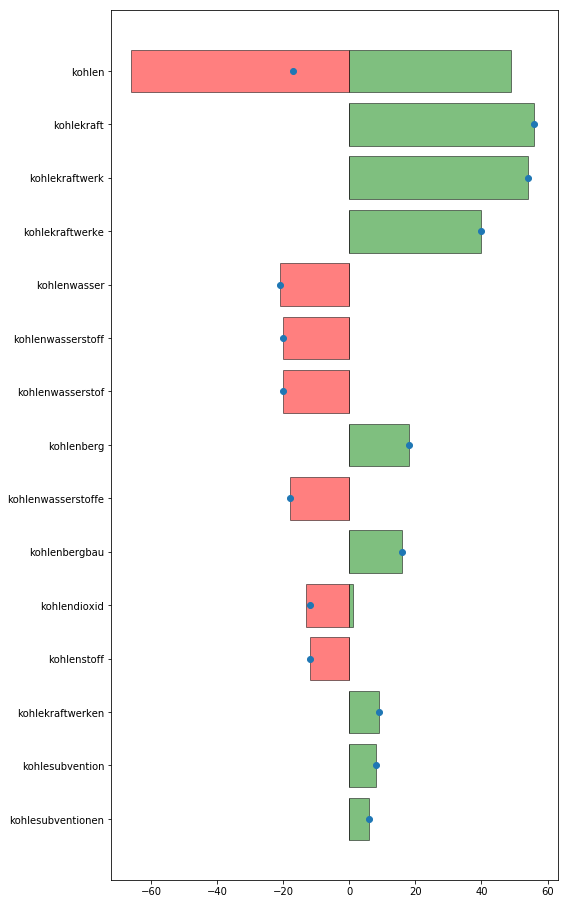

In [6]:
pdf = df[df['occurences']>5].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,16))

ax.barh(
    pdf.index, 
    pdf['yes'], 
    align='center',
    color='green', 
    edgecolor='black',
    linewidth=1,
    alpha=0.5
)
ax.barh(
    pdf.index, 
    pdf['no']*-1, 
    align='center',
    color='red', 
    edgecolor='black',
    linewidth=1,
    alpha=0.5
)
ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['kohle_compound'])
ax.invert_yaxis() 

ax.scatter(pdf['av'],pdf.index, zorder=5)

plt.show()

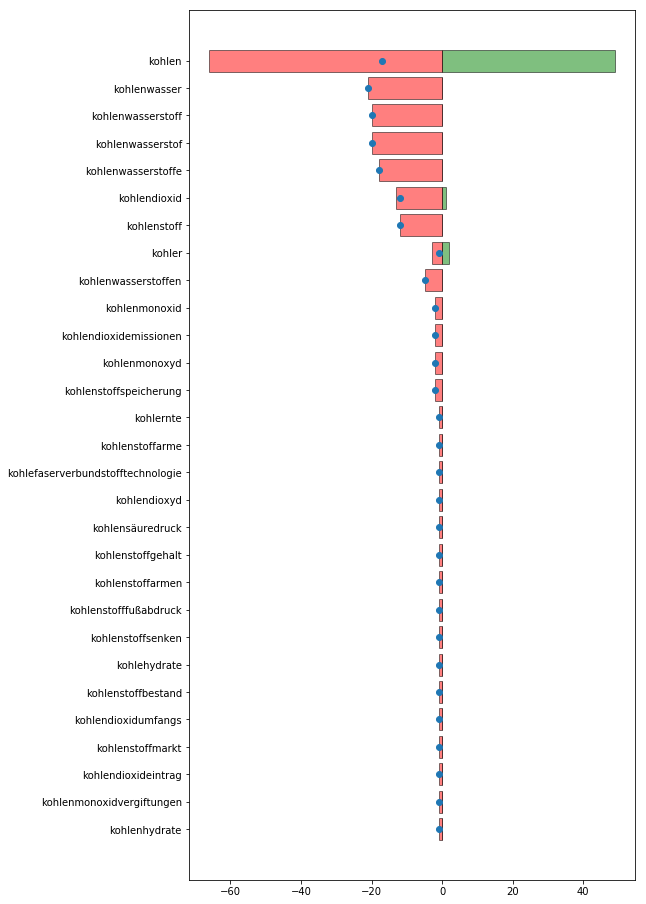

In [7]:
pdf = df[df['av']<0].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,16))

ax.barh(
    pdf.index, 
    pdf['yes'], 
    align='center',
    color='green', 
    edgecolor='black',
    linewidth=1,
    alpha=0.5
)
ax.barh(
    pdf.index, 
    pdf['no']*-1, 
    align='center',
    color='red', 
    edgecolor='black',
    linewidth=1,
    alpha=0.5
)
ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['kohle_compound'])
ax.invert_yaxis() 

ax.scatter(pdf['av'],pdf.index, zorder=5)

plt.show()

In [10]:
kc = "kohlendioxid"
kc_pars = pars.filter(text__icontains=kc)
expattern = f"kohle(?!{kc.replace('kohle','')})"
print(expattern)
kc_others = pars.filter(text__iregex=expattern)
kc_uids = set(kc_pars.values_list('utterance__id',flat=True))
kc_uids = kc_uids - set(kc_others.values_list('utterance__id',flat=True))
kc_dos = dos.filter(utterance__in=kc_uids)

for do in kc_dos.filter(relevant=1):
    print(do.utterance)
    print(do.user)
    print("\n##\n")
    for p in do.utterance.paragraph_set.all():
        print(p.text)

kohle(?!ndioxid)
Utterance object (1214490)
leia

##

Herr Präsident! Meine Damen und Herren! Die Opposition macht zwar viel Wind; aber davon dreht sich in Deutschland noch kein einziges Windrad.
Mit unserem Energiekonzept ist das anders. Es bietet erstmals seit langem einen belastbaren Fahrplan für die Energieversorgung von morgen. Das haben Rot-Grün und all unsere Vorgängerregierungen nicht geschafft.
Wir haben das geschafft. Ich möchte mich beim Kollegen Röttgen für die gute, sorgfältige Zusammenarbeit, die zu diesem Energiekonzept geführt hat, ausdrücklich bedanken.
re u E d n p s Ih e n a u n S D In ra g Ic V te g D h d le b m d S d d is is A v d Es geht dabei um den Weg ins Zeitalter der erneuerban Energien, es geht um aktiven Klimaschutz, es geht m Versorgungssicherheit, und es geht um bezahlbare nergiepreise. Ein wesentlicher Aspekt ist der Ausbau er Netze. Ohne Netzausbau gibt es kein Zeitalter der ereuerbaren Energien.
Das wissen auch die Damen und Herren von der Oposition. H